In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from IPython.display import display

In [111]:
def entropia(H):
    h = 0
    cat, cont = np.unique(H, return_counts=True)
    total = len(H)
    PX = cont/total
    h = -np.sum( PX * np.log2(PX) )
    n_cat = len(cat)
    hmax = -np.log2(1/n_cat)
    return h, hmax

In [113]:
df = pd.read_csv('../datasets/adult.csv')
X = df.copy()
for colname in X.columns:
    X[colname], _ = X[colname].factorize()
corr = df.corr()
abs_corr = np.abs(corr)
columns = df.columns
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


In [114]:
def get_values(df, columns):
    index = ['min', 'max', 'mean', 'std', 'minN', 'maxN', 'Q1', 'Q2 (median)', 'Q3', 'IRQ']
    n_cols = len(columns)
    m = len(index)
    values = np.zeros((m,n_cols))

    for i,column in enumerate(columns):
        if column == 'dteday': continue
        values[0,i] = np.min( df[column].values  )
        values[1,i] = np.max( df[column].values  )
        values[2,i] = np.mean( df[column].values  )
        values[3,i] = np.std( df[column].values  )
        values[4,i] = np.percentile( df[column].values, 25 )
        values[5,i] = np.percentile( df[column].values, 50 )
        values[6,i] = np.percentile( df[column].values, 75 )
        values[7,i] = values[6,i]-values[4,i]
        values[8,i] = values[4,i] - 1.5*values[7,i]
        values[9,i] = values[6,i] + 1.5*values[7,i]

    df_values = pd.DataFrame(values,columns=columns,index=index)
    return df_values

get_values(X, columns)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,72.000000,8.000000,15.000000,15.000000,6.000000,14.000000,5.000000,4.000000,1.000000,93.000000,41.000000,1.000000
mean,23.505881,2.309972,3.424465,3.424465,1.083781,4.666411,1.542397,0.221707,0.330795,7.498756,1.290317,0.240810
std,15.531052,1.225709,3.453529,3.453529,1.251361,3.386067,1.437409,0.627338,0.470499,12.561605,5.045296,0.427575
minN,11.000000,2.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
maxN,22.000000,2.000000,2.000000,2.000000,1.000000,4.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000
Q1,34.000000,2.000000,5.000000,5.000000,1.000000,7.000000,3.000000,0.000000,1.000000,9.000000,0.000000,0.000000
Q2 (median),23.000000,0.000000,4.000000,4.000000,1.000000,5.000000,3.000000,0.000000,1.000000,9.000000,0.000000,0.000000
Q3,-23.500000,2.000000,-5.000000,-5.000000,-1.500000,-5.500000,-4.500000,0.000000,-1.500000,-13.500000,0.000000,0.000000
IRQ,68.500000,2.000000,11.000000,11.000000,2.500000,14.500000,7.500000,0.000000,2.500000,22.500000,0.000000,0.000000


# Entropy

In [115]:
vals = []
for name in columns:
    entropy, max_ent = entropia(df[name].values)
    vals.append((entropy,max_ent))
vals = np.array(vals)
entropy_df = pd.DataFrame(data=vals, columns=['Entropy', 'Max-Entropy'], index=columns)
entropy_df

,Entropy,Max-Entropy
age,5.683324,6.189825
workclass,1.647977,3.169925
education,2.931351,4.000000
education-num,2.931351,4.000000
marital-status,1.833649,2.807355
occupation,3.516903,3.906891
relationship,2.154424,2.584963
race,0.798741,2.321928
sex,0.915736,1.000000
hours-per-week,3.479565,6.554589


# Mutual Information

In [116]:
def mutual_info_scores(X, y, discrete_features = True, name='---'):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name=f'MI Score {name}',index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [117]:
for column in columns:
    _X = X.copy()
    y = _X.pop(column)

    mi_scores = mutual_info_scores(_X, y, name=column)
    display(mi_scores.to_frame().T)

,marital-status,relationship,education,education-num,hours-per-week,occupation,income,workclass,sex,native-country,race
MI Score age,0.236709,0.196087,0.102331,0.102331,0.10001,0.072786,0.067647,0.051732,0.007843,0.007644,0.00411


,occupation,hours-per-week,age,education,education-num,relationship,marital-status,sex,income,native-country,race
MI Score workclass,0.326846,0.057269,0.055686,0.030505,0.030505,0.026681,0.026023,0.017198,0.017127,0.007489,0.004819


,education-num,occupation,age,income,native-country,workclass,hours-per-week,relationship,marital-status,race,sex
MI Score education,2.032979,0.223731,0.100512,0.065354,0.046683,0.035293,0.035043,0.031983,0.020417,0.00817,0.00338


,education,occupation,age,income,hours-per-week,native-country,relationship,workclass,marital-status,race,sex
MI Score education-num,2.032963,0.223014,0.099114,0.067105,0.045288,0.044514,0.038055,0.033893,0.02449,0.010386,0.010321


,relationship,age,sex,income,occupation,hours-per-week,education,education-num,workclass,race,native-country
MI Score marital-status,0.726238,0.241721,0.114423,0.107317,0.052965,0.047328,0.025239,0.025239,0.018297,0.015139,0.008362


,workclass,education,education-num,hours-per-week,sex,relationship,age,income,marital-status,native-country,race
MI Score occupation,0.324319,0.218602,0.218602,0.10986,0.101939,0.085447,0.074123,0.066224,0.054867,0.022009,0.012917


,marital-status,sex,age,income,occupation,hours-per-week,education,education-num,workclass,race,native-country
MI Score relationship,0.726824,0.273453,0.196644,0.113344,0.084818,0.078383,0.041285,0.041285,0.028659,0.015801,0.009688


,native-country,occupation,relationship,marital-status,workclass,hours-per-week,income,education,education-num,sex,age
MI Score race,0.09616,0.014429,0.013178,0.011057,0.010829,0.008958,0.008721,0.007176,0.007176,0.005989,0.004404


,relationship,marital-status,occupation,hours-per-week,income,workclass,education,education-num,race,age,native-country
MI Score sex,0.273798,0.114017,0.107363,0.046982,0.032554,0.016602,0.011946,0.011946,0.00752,0.005193,0.004946


,age,occupation,relationship,workclass,marital-status,income,education,education-num,sex,race,native-country
MI Score hours-per-week,0.106724,0.10367,0.076431,0.052214,0.048654,0.042492,0.038824,0.038824,0.037393,0.010296,0.006068


,race,education,education-num,occupation,marital-status,workclass,hours-per-week,relationship,income,age,sex
MI Score native-country,0.096265,0.042663,0.042663,0.018382,0.013098,0.011441,0.006216,0.006016,0.005223,0.004177,0.002224


,relationship,marital-status,age,education,education-num,occupation,hours-per-week,sex,workclass,race,native-country
MI Score income,0.114868,0.112127,0.070719,0.064417,0.064417,0.063019,0.042087,0.029546,0.014052,0.006821,0.004596


# Countplot

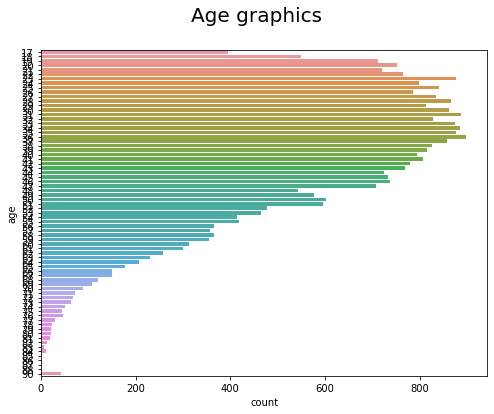

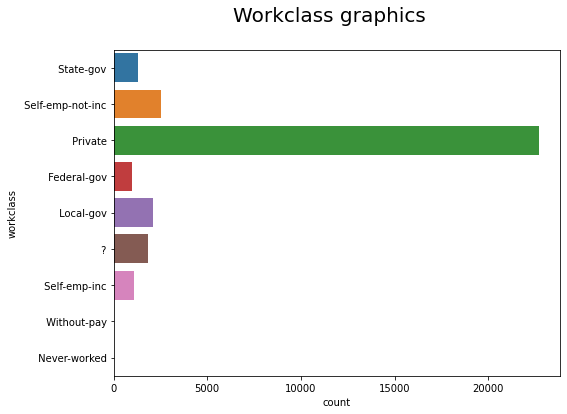

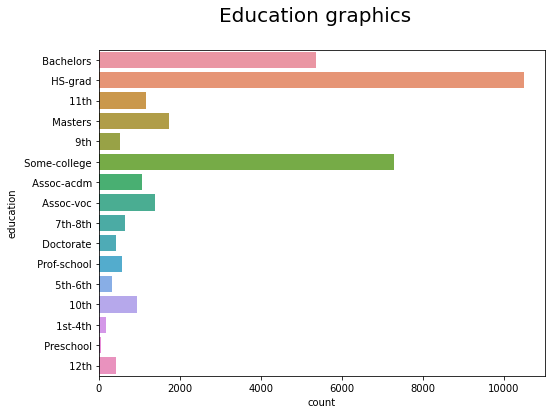

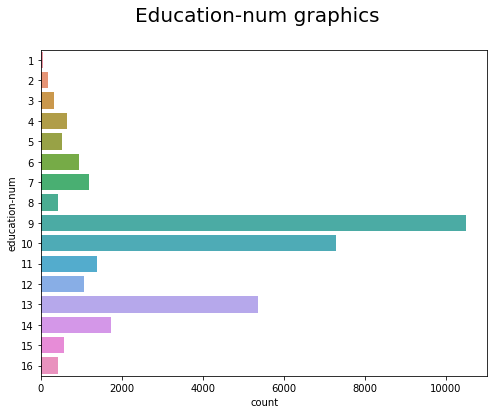

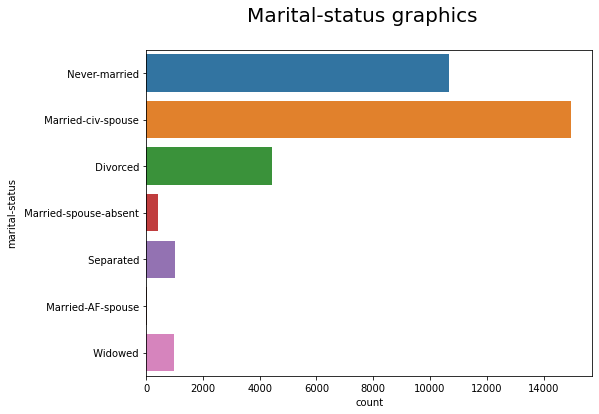

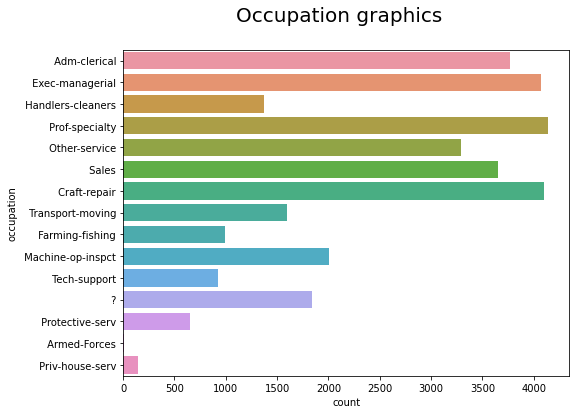

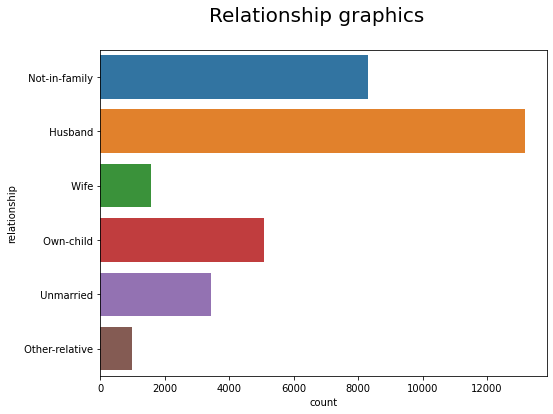

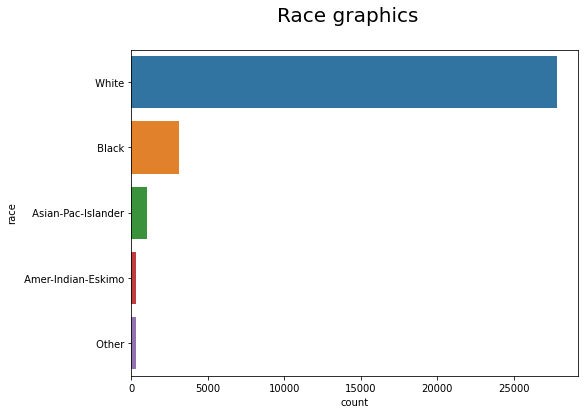

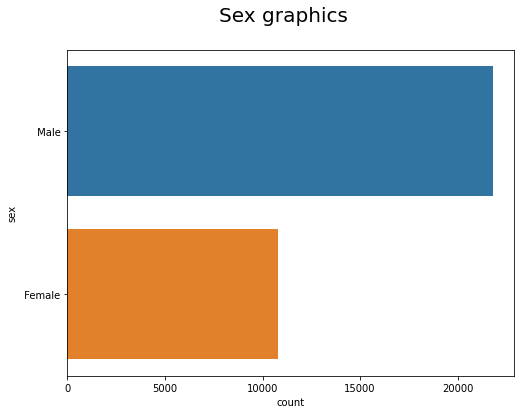

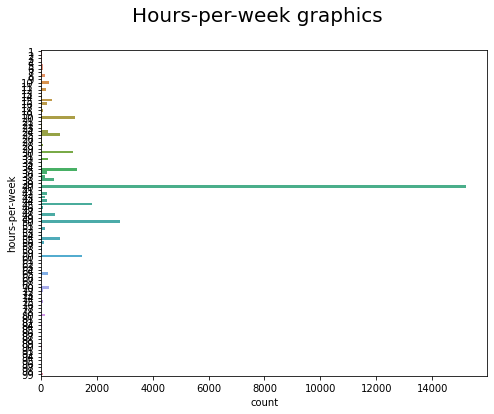

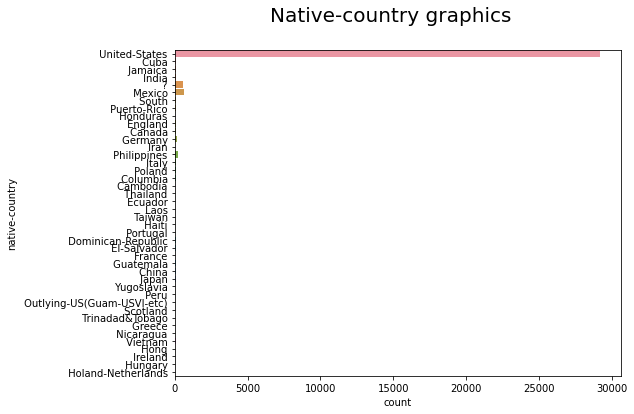

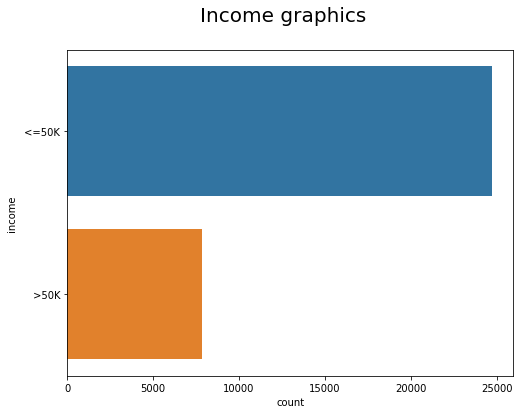

In [118]:
for name in columns:
    fig, ax = plt.subplots(figsize=(8,6))
    fig.suptitle(f'{name} graphics'.capitalize(), fontsize=20)
    ax = sb.countplot(data=df,y=name)
    plt.show()

# Visualization

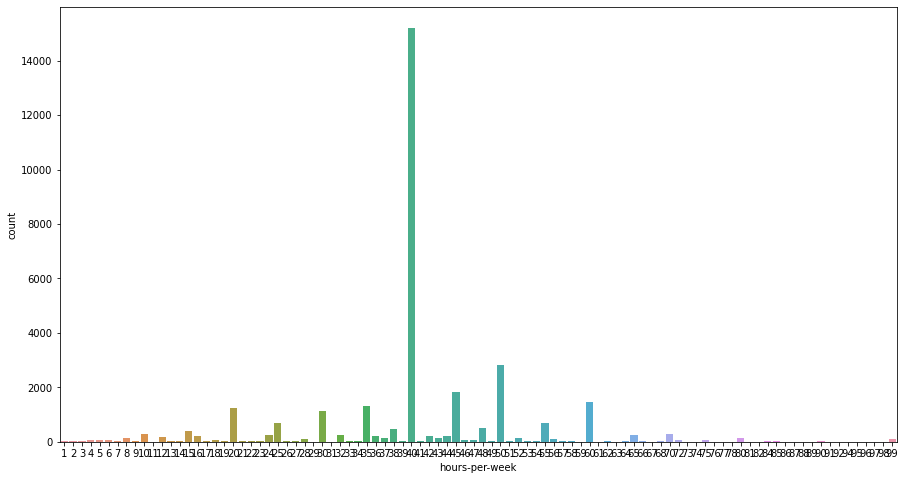

In [108]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sb.countplot(x="hours-per-week", data=df)
plt.show()

# Insights 

In this graphic we can see that the income from female is mostly almost less thank 50k.

In case of the men, the proportion is more well distributed.

Here we can conclude than women are being paying less than the men.

<AxesSubplot:xlabel='count', ylabel='sex'>

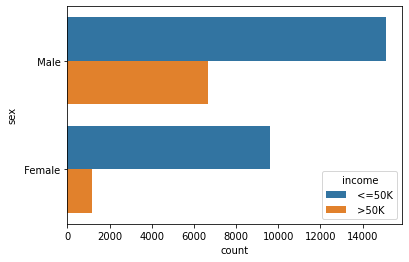

In [91]:
sb.countplot(y="sex", data=df, hue="income")

This graphic represents the education level for both genders. As we can see, there is a similar relation on both genders. 

Theres a significant increment on people who reach high school, the decreases significatly, then it increases again on Masters.

This makes us see that the distribution in the education level is almost the same for women as for men.

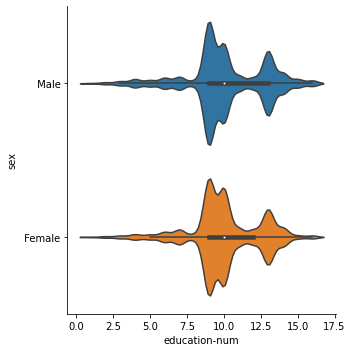

In [83]:
sb.catplot(y="sex", x="education-num", data=df, kind='violin')

When we compare relationship status, we can see that almost all men is married. Even so, most of the women is not in a family, what contrast with the results of the men.

Theres a few amount of woman who is married, as there are more own-child that married womans.

Also, the amount of not.in-family is almost the same for women and men even though the enquested women were less than men.

We can conclude that is more difficult for a woman to get into a comprimise relationship that the men.

<AxesSubplot:xlabel='count', ylabel='sex'>

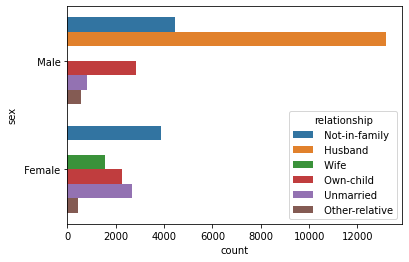

In [100]:
sb.countplot(y="sex", data=df, hue="relationship")

This distribution represents how are the works distributted between women and men.

Theres a significant contribution for the women in the adm-clerical sector, as well as priv-house servwhere almost all are women.

Other than that, almost all works are predominant by the men, being craft-rapir where the difference is brutal.

We can see then that the distribution of works is not equal for women and men.

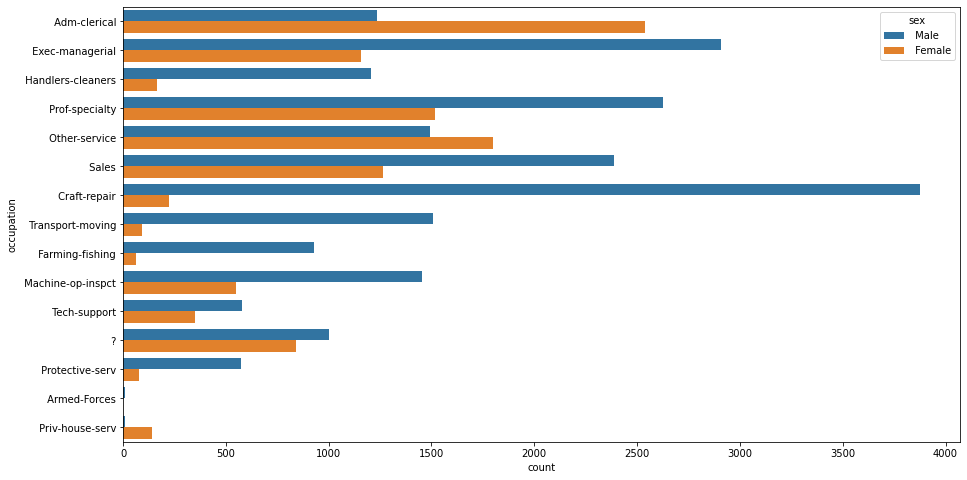

In [105]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sb.countplot(y="occupation", data=df, hue="sex")
plt.show()